In [11]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados históricos

In [3]:
files = os.listdir('./data/')

df_final = pd.DataFrame()
for file in files:
    filename = r"./data/" + file
    df = pd.read_csv(filename, sep=';')
    df_final = pd.concat([df_final, df.groupby(['Ano', "Mês", "Empresa"]).agg({"Acessos": "sum"}).reset_index()])

# Criar tabela com indicadores por período (Ano/Mês)

In [127]:
df_cr=[]
for ano in range(2007, 2024):
    for mes in range(1, 13):
        df_filt = df_final[(df_final['Ano']==ano) & (df_final['Mês'] == mes)].reset_index(drop=True)
        if len(df_filt) == 0:
            continue

        tot_acessos =  df_filt['Acessos'].sum()
        tot_empresas = len(df_filt)
        df_filt['mkt_share'] = df_filt['Acessos'] / tot_acessos * 100
        df_filt['ms_srd'] = df_filt['mkt_share'] ** 2
        df_filt['ms_ln'] = abs(np.log(df_filt['mkt_share'] / 100))
        df_filt['ms_times_lnms'] = df_filt['mkt_share'] / 100  * df_filt['ms_ln']


        lim_sup_theil = np.log(len(df_filt))

        cr4 = df_filt.sort_values('mkt_share', ascending=False).iloc[0:4, 4].sum()
        cr8 = df_filt.sort_values('mkt_share', ascending=False).iloc[0:8, 4].sum()
        hh = df_filt['ms_srd'].sum()
        theil = df_filt['ms_times_lnms'].sum() / lim_sup_theil

        data = {
            'periodo': f"{ano}-{mes:02d}",
            'n_empresas': tot_empresas,
            'cr4': cr4,
            'cr8': cr8,
            'hh': hh,
            'vh': 10000/hh,
            'theil': theil,
        }


        df_cr.append(data)
        
df_indicadores = pd.DataFrame(df_cr)

# Plotar

## Razões de Concentração

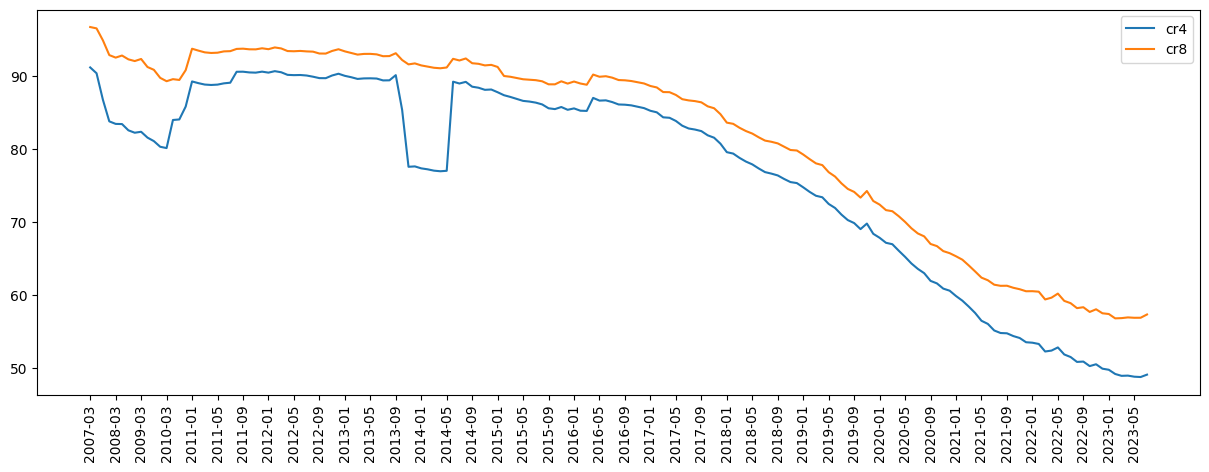

In [28]:
setps = 4
df_indicadores[['cr4', 'cr8']].plot(figsize=(15, 5))
plt.xticks(range(0, len(df_indicadores), setps), [df_indicadores.loc[idx, 'periodo'] for idx in range(0, len(df_indicadores), setps)], rotation = 90)
plt.show()

* Passagem de um mercado concentrado, com CR4 e 8 acima de 85% até 2017, quando há um gradual aumento na competitividade. Em julho de 2023, o CR4 era de 49,13%, e o CR8 de 57,36%, indicando um mercado de baixa concentração
* O mercado passou de 241 empresas em junho de 2007 para 7985 em julho de 2023.
* Houve alguma mudança institucional para isso? Novas regras? Tecnologia ficou mais barata?
* CR4 e CR8 próximos indicam que as 4 maiores empresas são as mais relevantes. As três maiores empresas, Claro, Vivo e Oi, respectivamente possuem 21,2%, 14,1% e 10,6% do mercado. Somadas as três, elas representam 45,9% do mercado.
* Queda brusca do cr4 em 2013 se deu pela entrada da Net  com a Claro. Mas foi logo revertido em 2014 (fusão neet claro, acessos da net foram para a Claro).


## HH

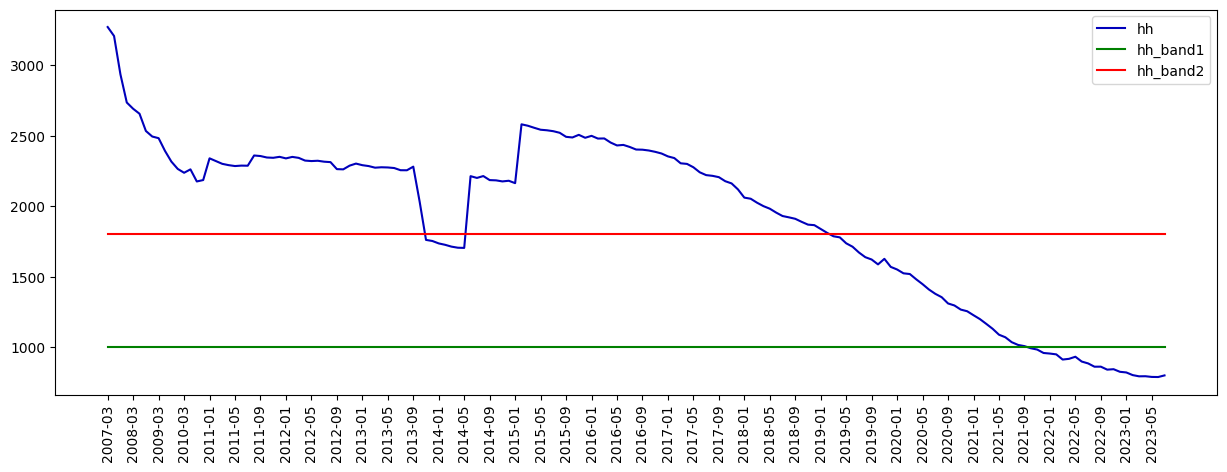

In [87]:
setps = 4
df_indicadores['hh_band1'] = 1000
df_indicadores['hh_band2'] = 1800

color_dict = {'hh_band1': '#FF0000', 'hh_band2': '#0000FF'}
df_indicadores[['hh', 'hh_band1', 'hh_band2']].plot(figsize=(15, 5), color=["#0000BB", "green", "#FF0000"])

plt.xticks(range(0, len(df_indicadores), setps), [df_indicadores.loc[idx, 'periodo'] for idx in range(0, len(df_indicadores), setps)], rotation = 90)
plt.show()

* O índice considera todas as firmas do mercado. 
* Reforça os achados do CR4 e CR8: o mercado concentrado até cerca de 2017, que passou a ser mais competitivo.
* Até 2019, o mercado estava acima da banda superior de 1800, considerada pelo FED como um mercado oligopolizado. Entre 2019 e 2022, há um aumento gradual da competição gradual. Em julho de 2023, o HH foi de 799,9, indicando um mercado competitivo.
* Analisando o número equivalente, com base no HH, vemos um cenário bem diferente. Em julho de 2023, o número equivalente de empresas foi de 12,5. Uma vez que no mercado há 7985 empresas, há uma diferença grande entre o número de empresas necessário para que todas tivessem o mesmo tamanho. Isso indica concentração. De fato, percebemos que 5432 delas tiveram menos do que 1000 acessos. E 7692 tiveram menos do que 10.000 acessos.


## Entropia de Theil

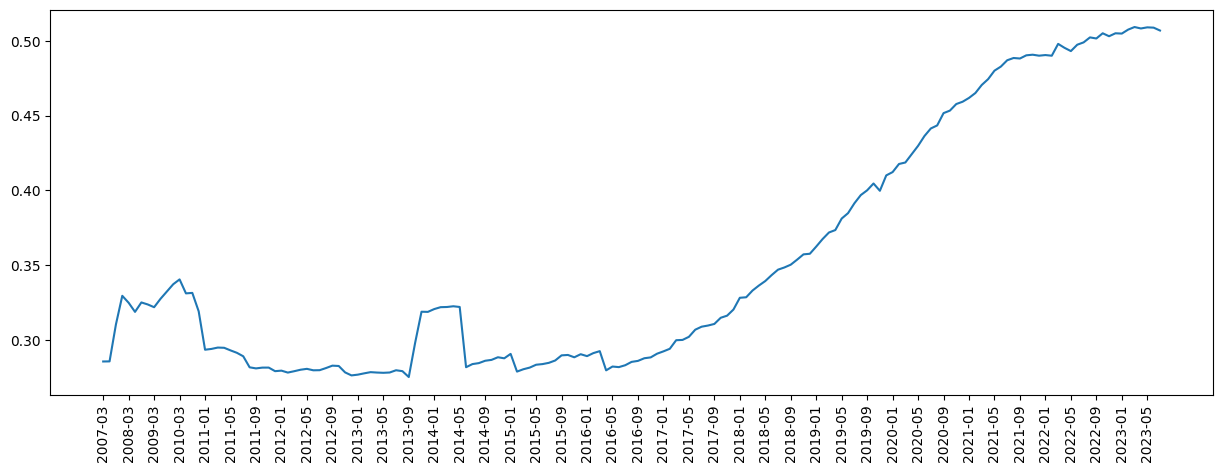

In [129]:
setps = 4
df_indicadores['theil'].plot(figsize=(15, 5))
plt.xticks(range(0, len(df_indicadores), setps), [df_indicadores.loc[idx, 'periodo'] for idx in range(0, len(df_indicadores), setps)], rotation = 90)
plt.show()

* Theil foi normalizado: dividindo o valor obtido pelo limite superior
* Quanto mais próximo de 1, maior a entropia
* Novamente, verificamos um crescimento da entropia, portanto, crescimento da competitividade do mercado


# Volatilidade

In [162]:
ano1 = 2013
mes1 = 7

ano2 = 2023
mes2 = 7

df_filt1 = df_final[(df_final['Ano']==ano1) & (df_final['Mês'] == mes1)].reset_index(drop=True)
df_filt1['mkt_share'] = df_filt1['Acessos'] / df_filt1['Acessos'].sum()

df_filt2 = df_final[(df_final['Ano']==ano2) & (df_final['Mês'] == mes2)].reset_index(drop=True)
df_filt2['mkt_share'] = df_filt2['Acessos'] / df_filt2['Acessos'].sum()

df_merge = df_filt1.merge(df_filt2, on='Empresa', suffixes=['_1', '_2'], how='outer').fillna(0) # pegar todas as firmas, as que não estiverem em um momento t, infere-se 0

df_merge['abs_diff'] = abs(df_merge['mkt_share_2'] - df_merge['mkt_share_1'])

volat = df_merge['abs_diff'].sum() / 2
print(f"Volatilidade entre {ano1}/{mes1} e {ano2}/{mes2}: {volat}")

n_emp1 = df_indicadores[df_indicadores['periodo'] == f'{ano1}-{mes1:02d}']['n_empresas'].values[0]
n_emp2 = df_indicadores[df_indicadores['periodo'] == f'{ano2}-{mes2:02d}']['n_empresas'].values[0]

print(f"Empresas em {ano1}-{mes1:02d}: {n_emp1} \nEmpresas em  {ano2}-{mes2:02d}: {n_emp2}")

Volatilidade entre 2013/7 e 2023/7: 0.49572363578655465
Empresas em 2013-07: 1620 
Empresas em  2023-07: 7985


# Simulação Fusão

In [230]:
def fuse_companies(companies: list[str], df:pd.DataFrame) -> pd.DataFrame:
    idxs = [df[df['Empresa'] == company].index.values[0] for company in companies]
    
    access = [df.loc[idx, "Acessos"] for idx in idxs]

    new_data = {'Ano': ano, "Mês": mes, "Empresa": "FUSÃO", 'Acessos': np.sum(access)}

    df_new_data = pd.concat([df_filt, pd.DataFrame([new_data])])
    df_new_data = df_new_data.drop(idxs)
    return df_new_data

In [238]:
ano=2023
mes=7

empresas_fusao = ["OI", "VIVO"]
df_filt = df_final[(df_final['Ano']==ano) & (df_final['Mês'] == mes)].reset_index(drop=True)

df_new_data = fuse_companies(empresas_fusao, df_filt)

tot_acessos =  df_new_data['Acessos'].sum()
tot_empresas = len(df_new_data)
df_new_data['mkt_share'] = df_new_data['Acessos'] / tot_acessos * 100
df_new_data['ms_srd'] = df_new_data['mkt_share'] ** 2
df_new_data['ms_ln'] = abs(np.log(df_new_data['mkt_share'] / 100))
df_new_data['ms_times_lnms'] = df_new_data['mkt_share'] / 100  * df_new_data['ms_ln']


lim_sup_theil = np.log(len(df_new_data))

cr4 = df_new_data.sort_values('mkt_share', ascending=False).iloc[0:4, 4].sum()
cr8 = df_new_data.sort_values('mkt_share', ascending=False).iloc[0:8, 4].sum()
hh = df_new_data['ms_srd'].sum()
theil = df_new_data['ms_times_lnms'].sum() / lim_sup_theil

data = {
    'periodo': f"{ano}-{mes:02d}",
    'n_empresas': tot_empresas,
    'cr4': cr4,
    'cr8': cr8,
    'hh': hh,
    'vh': 10000/hh,
    'theil': theil,
}
